In [1]:
import os
from keras.models import Model
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, Activation, BatchNormalization
from keras.applications.resnet import ResNet50
from keras.models import Sequential
from keras.layers import GlobalAveragePooling2D, Dense, MaxPooling2D
from keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt

2024-04-08 12:51:43.389386: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0


In [2]:
# Data preparation
dataset_dir= 'TNB_split'
input_shape=(224, 224, 3)
batch_size=8
num_classes=5

In [3]:
#Data augmentation
train_datagen=ImageDataGenerator(
    rescale=1./255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True)

test_datagen=ImageDataGenerator(
    rescale=1./255)

In [4]:
#Generate the train dataset, validation dataset and test dataset
train_generator=train_datagen.flow_from_directory(
    os.path.join(dataset_dir, 'train'),
    target_size=input_shape[:2],
    batch_size=batch_size,
    class_mode='categorical', #skin has two classes: benign and malignant
    )

validation_generator=train_datagen.flow_from_directory(
    os.path.join(dataset_dir, 'val'),
    target_size=input_shape[:2],
    batch_size=batch_size,
    shuffle=False,
    class_mode='categorical', #skin has two classes: benign and malignant
    )

test_generator=test_datagen.flow_from_directory(
    os.path.join(dataset_dir, 'test'),
    target_size=input_shape[:2],
    batch_size=batch_size,
    shuffle=False,
    class_mode='categorical', #skin has two classes: benign and malignant
    )

Found 2562 images belonging to 5 classes.
Found 369 images belonging to 5 classes.
Found 731 images belonging to 5 classes.


In [5]:
resnet_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

2024-04-08 12:51:45.445319: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcuda.so.1
2024-04-08 12:51:45.472419: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1733] Found device 0 with properties: 
pciBusID: 0000:e3:00.0 name: NVIDIA GeForce RTX 4090 computeCapability: 8.9
coreClock: 2.55GHz coreCount: 128 deviceMemorySize: 23.65GiB deviceMemoryBandwidth: 938.86GiB/s
2024-04-08 12:51:45.472462: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0
2024-04-08 12:51:45.476693: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcublas.so.11
2024-04-08 12:51:45.476795: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcublasLt.so.11
2024-04-08 12:51:45.478161: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcu

In [6]:
# Freeze the layers in the pre-trained models
for layer in resnet_model.layers:
    layer.trainable = False

In [7]:
# create a new model and add the VGG base model
model = Sequential()
model.add(resnet_model)

In [8]:
# Add additional layers for classification
model.add(Flatten())
model.add(Dense(256, activation='relu'))  # first FC layer
model.add(Dense(5, activation='softmax'))  # second FC layer

In [9]:
#compile the model
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [10]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50 (Functional)        (None, 7, 7, 2048)        23587712  
_________________________________________________________________
flatten (Flatten)            (None, 100352)            0         
_________________________________________________________________
dense (Dense)                (None, 256)               25690368  
_________________________________________________________________
dense_1 (Dense)              (None, 5)                 1285      
Total params: 49,279,365
Trainable params: 25,691,653
Non-trainable params: 23,587,712
_________________________________________________________________


In [11]:
#Train the model
history=model.fit(train_generator, epochs=50, validation_data=(validation_generator), verbose=1)

Epoch 1/50


2024-04-08 12:51:48.545284: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:176] None of the MLIR Optimization Passes are enabled (registered 2)
2024-04-08 12:51:48.545801: I tensorflow/core/platform/profile_utils/cpu_utils.cc:114] CPU Frequency: 2000000000 Hz
2024-04-08 12:52:05.384052: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudnn.so.8
2024-04-08 12:52:06.192561: I tensorflow/stream_executor/cuda/cuda_dnn.cc:359] Loaded cuDNN version 8101
2024-04-08 12:52:07.103753: W tensorflow/stream_executor/gpu/asm_compiler.cc:191] Falling back to the CUDA driver for PTX compilation; ptxas does not support CC 8.9
2024-04-08 12:52:07.103776: W tensorflow/stream_executor/gpu/asm_compiler.cc:194] Used ptxas at /usr/local/cuda-11.2/bin/ptxas
2024-04-08 12:52:07.103850: W tensorflow/stream_executor/gpu/redzone_allocator.cc:314] Unimplemented: /usr/local/cuda-11.2/bin/ptxas ptxas too old. Falling back to the driver to compile.
Re

  3/321 [..............................] - ETA: 24s - loss: 11.9925 - accuracy: 0.1389       

2024-04-08 12:52:08.005683: I tensorflow/stream_executor/cuda/cuda_blas.cc:1838] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


321/321 [==============================] - 70s 159ms/step - loss: 3.8673 - accuracy: 0.4223 - val_loss: 1.1863 - val_accuracy: 0.4905
Epoch 2/50
321/321 [==============================] - 47s 145ms/step - loss: 1.2406 - accuracy: 0.4964 - val_loss: 1.1861 - val_accuracy: 0.4932
Epoch 3/50
321/321 [==============================] - 47s 146ms/step - loss: 1.2125 - accuracy: 0.5181 - val_loss: 1.1927 - val_accuracy: 0.5041
Epoch 4/50
321/321 [==============================] - 46s 144ms/step - loss: 1.1775 - accuracy: 0.5492 - val_loss: 1.2240 - val_accuracy: 0.5637
Epoch 5/50
321/321 [==============================] - 46s 142ms/step - loss: 1.1107 - accuracy: 0.5648 - val_loss: 1.0232 - val_accuracy: 0.6152
Epoch 6/50
321/321 [==============================] - 48s 149ms/step - loss: 1.0944 - accuracy: 0.6000 - val_loss: 0.9827 - val_accuracy: 0.6260
Epoch 7/50
321/321 [==============================] - 47s 145ms/step - loss: 1.0449 - accuracy: 0.6078 - val_loss: 1.0103 - val_accuracy: 0.6

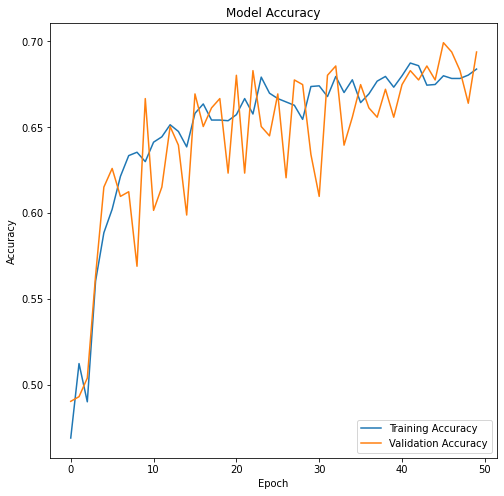

In [12]:
#Training accuracy and validation accuracy graph
plt.figure(figsize=(8,8))
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Training Accuracy', 'Validation Accuracy'], loc ='lower right')
plt.show()

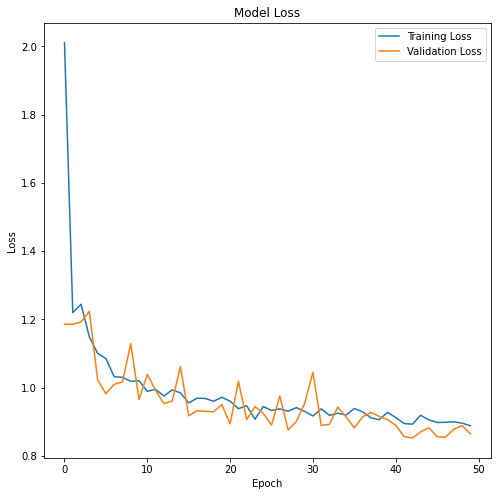

In [13]:
#Trainig loss and validation loss graph
plt.figure(figsize=(8,8))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Training Loss', 'Validation Loss'], loc ='upper right')
plt.show()

In [14]:
# Evaluate the model on the testing dataset
test_loss, test_acc = model.evaluate(test_generator)
print('Test loss:', test_loss)
print('Test accuracy:', test_acc)

92/92 [==============================] - 5s 49ms/step - loss: 0.9347 - accuracy: 0.6881
Test loss: 0.9347451329231262
Test accuracy: 0.6880984902381897


In [15]:
from sklearn.metrics import confusion_matrix, f1_score, roc_curve, auc

In [16]:
# Get the prediction results of the model
y_pred = model.predict(test_generator)
y_true = test_generator.classes

Confusion Matrix:
[[  0  56  18   0   0]
 [  0 154  45   0   0]
 [  0  12 349   0   0]
 [  0  40  19   0   0]
 [  0  26  12   0   0]]


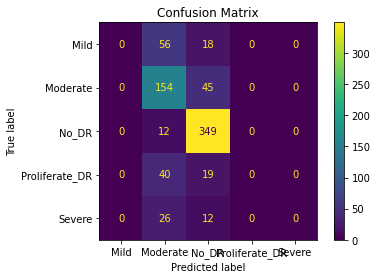

In [17]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import numpy as np
# Convert probabilities to categories
y_pred_labels = np.argmax(y_pred, axis=1)
class_labels = list(test_generator.class_indices.keys())

# Compute the confusion matrix
confusion = confusion_matrix(y_true, y_pred_labels)

print("Confusion Matrix:")
print(confusion)

# Visualize confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=confusion, display_labels=class_labels)
disp.plot(cmap='viridis', values_format='d')
plt.title('Confusion Matrix')
plt.show()

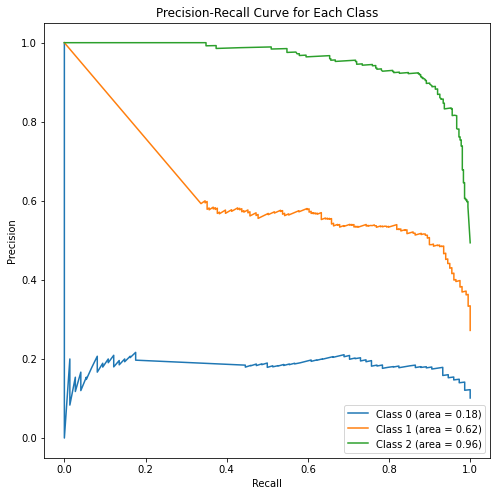

In [18]:
from sklearn.metrics import precision_recall_curve, auc
import matplotlib.pyplot as plt
from sklearn.preprocessing import label_binarize

# Binarize multi-category labels
y_true_bin = label_binarize(y_true, classes=[0, 1, 2])  # 0, 1, 2是你的类别标签

#Initialize drawing
plt.figure(figsize=(8, 8))

# Calculate precision-recall curve for each category
for i in range(y_true_bin.shape[1]):
    precision, recall, _ = precision_recall_curve(y_true_bin[:, i], y_pred[:, i])
    pr_auc = auc(recall, precision)
    plt.plot(recall, precision, label='Class {} (area = {:0.2f})'.format(i, pr_auc))

# Draw legends, labels, etc.
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve for Each Class')
plt.legend(loc='lower right')
plt.show()

In [19]:
# Compute ROC curve and ROC area for each class
from sklearn.metrics import confusion_matrix, f1_score, roc_curve, auc
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(num_classes):
    fpr[i], tpr[i], _ = roc_curve(y_true == i, y_pred[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

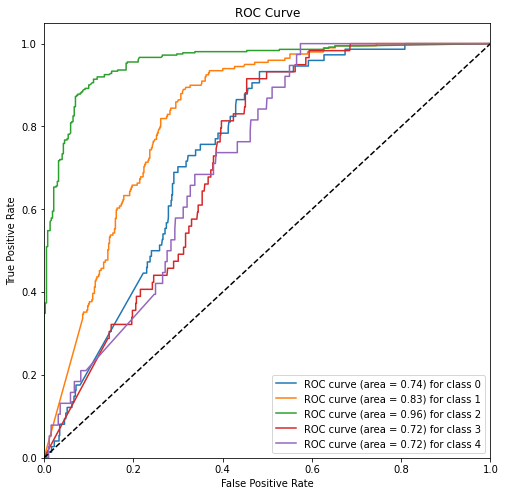

In [20]:
# Plot ROC curve
plt.figure(figsize=(8, 8))
for i in range(num_classes):
    plt.plot(fpr[i], tpr[i], label='ROC curve (area = %0.2f) for class %d' % (roc_auc[i], i))
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.show()

In [21]:
# Import necessary libraries
from sklearn.metrics import f1_score

# Assuming y_true and y_pred_labels are defined

# Compute the F1 score (micro)
f1_micro = f1_score(y_true, y_pred_labels, average='micro')
print('F1-score (micro):', f1_micro)

# Compute the F1 score (macro)
f1_macro = f1_score(y_true, y_pred_labels, average='macro')
print('F1-score (macro):', f1_macro)

# Compute the F1 score (weighted)
f1_weighted = f1_score(y_true, y_pred_labels, average='weighted')
print('F1-score (weighted):', f1_weighted)

F1-score (micro): 0.6880984952120383
F1-score (macro): 0.30012054716152303
F1-score (weighted): 0.6009052468816573


In [22]:

# Initialize variables to store overall sensitivity and specificity
overall_sensitivity = 0
overall_specificity = 0

# Loop through each class
for i, class_label in enumerate(class_labels):
    # Extract TP, FP, FN, and TN for the current class
    TP = confusion[i, i]
    FP = sum(confusion[:, i]) - TP
    FN = sum(confusion[i, :]) - TP
    TN = sum(sum(confusion)) - TP - FP - FN
    
    # Compute sensitivity and specificity for the current class
    sensitivity = TP / (TP + FN) if (TP + FN) != 0 else 0
    specificity = TN / (TN + FP) if (TN + FP) != 0 else 0
    
    # Print or store sensitivity and specificity for the current class
    print(f'Class {class_label} Sensitivity: {sensitivity:.4f}')
    print(f'Class {class_label} Specificity: {specificity:.4f}')
    
    # Accumulate sensitivity and specificity for overall calculation
    overall_sensitivity += sensitivity
    overall_specificity += specificity

# Calculate overall sensitivity and specificity
num_classes = len(class_labels)
overall_sensitivity /= num_classes
overall_specificity /= num_classes

# Print or store overall sensitivity and specificity
print(f'Overall Sensitivity: {overall_sensitivity:.4f}')
print(f'Overall Specificity: {overall_specificity:.4f}')


Class Mild Sensitivity: 0.0000
Class Mild Specificity: 1.0000
Class Moderate Sensitivity: 0.7739
Class Moderate Specificity: 0.7481
Class No_DR Sensitivity: 0.9668
Class No_DR Specificity: 0.7459
Class Proliferate_DR Sensitivity: 0.0000
Class Proliferate_DR Specificity: 1.0000
Class Severe Sensitivity: 0.0000
Class Severe Specificity: 1.0000
Overall Sensitivity: 0.3481
Overall Specificity: 0.8988


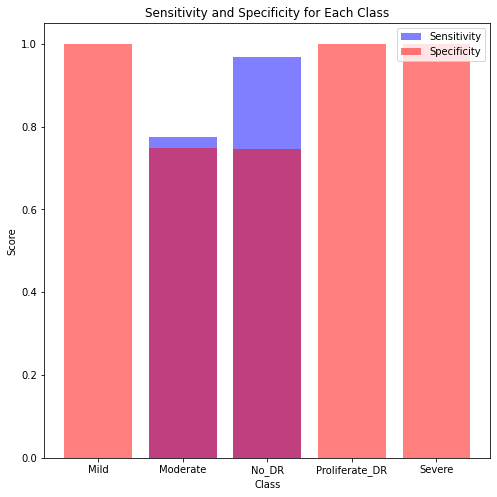

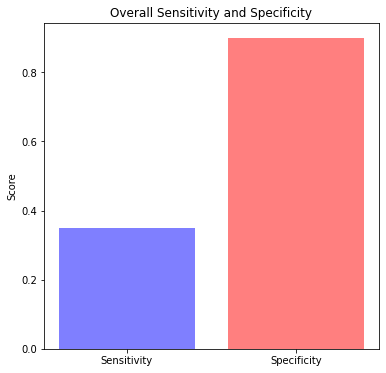

In [23]:
import matplotlib.pyplot as plt

# Initialize variables to store overall sensitivity and specificity
overall_sensitivity = 0
overall_specificity = 0
sensitivity_scores = []
specificity_scores = []

# Loop through each class
for i, class_label in enumerate(class_labels):
    # Extract TP, FP, FN, and TN for the current class
    TP = confusion[i, i]
    FP = sum(confusion[:, i]) - TP
    FN = sum(confusion[i, :]) - TP
    TN = sum(sum(confusion)) - TP - FP - FN
    
    # Compute sensitivity and specificity for the current class
    sensitivity = TP / (TP + FN) if (TP + FN) != 0 else 0
    specificity = TN / (TN + FP) if (TN + FP) != 0 else 0
    
    # Accumulate sensitivity and specificity for overall calculation
    overall_sensitivity += sensitivity
    overall_specificity += specificity
    
    # Store sensitivity and specificity for current class
    sensitivity_scores.append(sensitivity)
    specificity_scores.append(specificity)

# Calculate overall sensitivity and specificity
num_classes = len(class_labels)
overall_sensitivity /= num_classes
overall_specificity /= num_classes

# Plotting sensitivity and specificity for each class
plt.figure(figsize=(8, 8))
plt.bar(range(len(class_labels)), sensitivity_scores, color='b', alpha=0.5, label='Sensitivity')
plt.bar(range(len(class_labels)), specificity_scores, color='r', alpha=0.5, label='Specificity')
plt.xticks(range(len(class_labels)), class_labels)
plt.xlabel('Class')
plt.ylabel('Score')
plt.title('Sensitivity and Specificity for Each Class')
plt.legend()
plt.show()

# Plotting overall sensitivity and specificity
plt.figure(figsize=(6, 6))
plt.bar(['Sensitivity', 'Specificity'], [overall_sensitivity, overall_specificity], color=['b', 'r'], alpha=0.5)
plt.ylabel('Score')
plt.title('Overall Sensitivity and Specificity')
plt.show()
